### packages

In [1]:
################################################################################################
################################################################################################

import numpy as np

import pandas as pd

################################################################################################
################################################################################################

import pulp

################################################################################################
################################################################################################

import networkx as nx

################################################################################################
################################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import seaborn as sns

from matplotlib.transforms import Bbox

################################################################################################
################################################################################################

from scipy.optimize import minimize

################################################################################################
################################################################################################

from model.Matching import Bipartite_matching

################################################################################################
################################################################################################

import time

################################################################################################
################################################################################################


import warnings

warnings.filterwarnings('ignore')

### parameters

\begin{equation}
u_{o,d,i} = \overbrace{\alpha_{0,o}}^{\textrm{constant term}} - \overbrace{\alpha_{1,o} \cdot f_{o,d,i}}^{\textrm{order fare}} - \overbrace{ \alpha_{2,o} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall o \in O,
\label{eq:order utility}
\end{equation}

\begin{equation}
v_{o,d,i} = \overbrace{\beta_{0,d}}^{\textrm{constant term}} + \overbrace{\beta_{1,d} \cdot w_{o,d,i}}^{\textrm{wage}} - \overbrace{ \beta_{2,d} \cdot \tau_{o,d} }^{\textrm{pick-up time}}, \forall d \in D
\label{eq:driver utility}
\end{equation}

where

\begin{align}
\begin{split}
&f_{o,d,2}=\theta_{0}+ \theta_{1}\cdot \textrm{ETD}_{o} + \theta_{2}\cdot \textrm{ETT}_{o}
\label{eq: linear fare}
\end{split}
\end{align}

\begin{align}
\begin{split}
&w_{o,d,2}=\lambda f_{o,d,2}
\label{eq: linear wage}
\end{split}
\end{align}

\begin{align}
\begin{split}
&\max_{x_{o,d,2}} \sum_{o\in O} \sum_{d\in D}   \mathcal{P}_{o,d,i} \cdot x_{o,d,i}
\label{eq:objective of platform}
\end{split}\\
\begin{split}
\text{subject to}&\sum_{d \in D} x_{o,d,2} \leq  1, \forall o \in O
\label{eq:constrain 1 of platform}
\end{split}\\
\begin{split}
&\sum_{o \in O} x_{o,d,2} \leq 1, \forall d \in D
\label{eq:constrain 2 of platform}
\end{split}
\end{align}
\begin{align}
\mathcal{P}_{o,d,2}= \frac{(f_{o,d,2}-w_{o,d,2})}{\tau_{o,d}}
\end{align}

In [39]:
################################################################################################
################################################################################################

order_num=10

driver_num=10

################################################################################################
################################################################################################

theta_0=3.11

theta_1=0.41

theta_2=1.21

lambda_=0.78

# kappa_=1.0


################################################################################################
################################################################################################


theta_0_space=[2,3]

theta_1_space=[.2,.5]

theta_2_space=[.9,1.2]

lambda_space=[.6,.9]

# kappa_space=[1.0,5.0]

################################################################################################
################################################################################################

alpha0=0.0

alpha1=3.2

alpha2=0.6

################################################################################################
################################################################################################

beta0=0.0

beta1=2.0

beta2=0.5

################################################################################################
################################################################################################

u_decline=-60

v_decline=10

################################################################################################
################################################################################################

ETD=np.random.uniform(3,10,order_num)

ETT=np.random.uniform(3,10,order_num)

################################################################################################
################################################################################################

Tau=np.random.uniform(3,10,[order_num,driver_num])


### generate strategy of platform 2

In [40]:
################################################################################################
################################################################################################

Fare2=theta_0*np.ones(order_num)+theta_1*ETD+theta_2*ETT

Fare2=np.tile(np.array([Fare2]).transpose(), (1,driver_num))

################################################################################################
################################################################################################

Wage2=lambda_*Fare2

################################################################################################
################################################################################################

Weights2=(Fare2-Wage2)/Tau

X2=Bipartite_matching(Weights2)

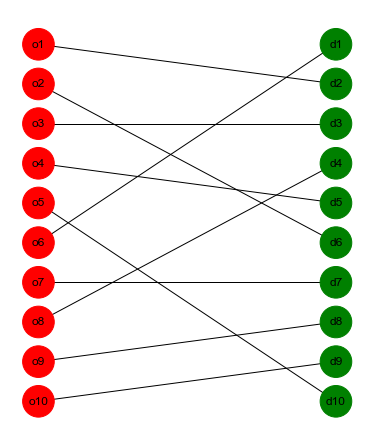

In [41]:
################################################################################################
################################################################################################

G2 = nx.Graph()

order_nodes=['o'+str(o+1) for o in range(order_num)]

driver_nodes=['d'+str(d+1) for d in range(driver_num)]

for node in order_nodes:
    
    G2.add_node(node, level=0)
    
for node in driver_nodes:
    
    G2.add_node(node, level=1)
    
################################################################################################
################################################################################################

for o in range(order_num):

    for d in range(driver_num):
        
        if X2[o][d]==1:

            G2.add_edge('o'+str(o+1),'d'+str(d+1))

################################################################################################
################################################################################################

color_map = ['red' if 'o' in node else 'green' for node in G2.nodes()]  

pos = nx.multipartite_layout(G2, subset_key="level")

plt.figure(figsize=(5,6)) 

nx.draw(G2,pos,with_labels = True,node_size=1000,node_color=color_map)

plt.show()
   
        

### Observable static competition

The OS competition assumes fare, waging, and matching decisions  $\theta_{0}$, $\theta_{1}$, $\theta_{2}$, and $\lambda$ are completely available to platform 1 at each time step. Accordingly, $f_{o,d,2}$, $w_{o,d,2}$, $x_{o,d,2}$, $u_{o,d,2}$, and $v_{o,d,2}$ are also completely visible to platform 1.



In [63]:
# optimization.X2[0,:]



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1, 5, 2, 4, 9, 0, 6, 3, 7, 8]))

In [67]:
class OS_optimization(object):
    
    ################################################################################################
    ################################################################################################
    
    def __init__(self,Fare2,Wage2,X2,u_decline,v_decline,Tau):
        
        ################################################################################################
        
        self.Fare2=Fare2 # fare of platform 2
        
        self.Wage2=Wage2 # wage of platform 2
        
        self.X2=X2 # matching solution of platform 2
        
        ################################################################################################
        
        self.order_num,self.driver_num=X2.shape[0],X2.shape[1]
        
        ################################################################################################
        
        self.Tau=Tau # pickup time of platform 2
        
        ################################################################################################
        
        self.u_decline=u_decline
        
        self.v_decline=v_decline

        ################################################################################################
 
        self.U2=alpha0*np.ones([self.order_num,self.driver_num])-alpha1*Fare2-alpha2*Tau

        ################################################################################################

        self.V2=beta0*np.ones([self.order_num,self.driver_num])+beta1*Wage2-beta2*Tau
        
        ################################################################################################
        
        self.matched_order_driver_pair={}

        self.matched_driver_order_pair={}

        for o,d in zip(np.nonzero(self.X2)[0],np.nonzero(self.X2)[1]):

            self.matched_order_driver_pair[o]=d

            self.matched_driver_order_pair[d]=o
        
    ################################################################################################
        
    def profit(self,X,o,d):
        
       ################################################################################################
        
        u1=alpha0-alpha1*X[0]-alpha2*self.Tau[o,d]
        
        v1=beta0+beta1*X[1]-beta2*self.Tau[o,d]
        
        ################################################################################################
        
        u0=self.u_decline
        
        v0=self.v_decline
        
        ################################################################################################
        
        u2=self.U2[o,self.matched_order_driver_pair[o]]
        
        v2=self.V2[self.matched_driver_order_pair[d],d]
        
        ################################################################################################
        
        #*self.X2[o,d]
        
        p=np.exp(u1)/(np.exp(u0)+np.exp(u2)+np.exp(u1))
    
        q=np.exp(v1)/(np.exp(v0)+np.exp(v2)+np.exp(v1))
        
        ################################################################################################
        
        return -1*p*q*(X[0]-X[1])
    
    ################################################################################################
    
    def solve(self):
        
        ################################################################################################
        
        Fare1,Wage1=np.zeros([self.order_num,self.driver_num]),np.zeros([self.order_num,self.driver_num])
        
        ################################################################################################

        for o in range(self.order_num):

            for d in range(self.driver_num):
                
                fw_opt = minimize(self.profit,[self.Fare2[o,d],self.Wage2[o,d]],args=(o,d),bounds=((0, None), (0, None)))
        
                Fare1[o,d]=fw_opt.x[0]

                Wage1[o,d]=fw_opt.x[1]
                
        ################################################################################################
        
        U1=alpha0*np.ones([self.order_num,self.driver_num])-alpha1*Fare1-alpha2*Tau

        V1=beta0*np.ones([self.order_num,self.driver_num])+beta1*Wage1-beta2*Tau
        
        ################################################################################################
        
        u0=self.u_decline
        
        v0=self.v_decline
        
        ################################################################################################
        
        Weights1=np.ones([self.order_num,self.driver_num])
        
        for o in range(self.order_num):

            for d in range(self.driver_num):
        
                p=np.exp(U1[o,d])/(np.exp(u0)+np.exp(self.U2[o,d])*self.X2[o,d]+np.exp(U1[o,d]))

                q=np.exp(V1[o,d])/(np.exp(v0)+np.exp(self.V2[o,d])*self.X2[o,d]+np.exp(V1[o,d]))
                
                Weights1[o,d]=p*q*(Fare1[o,d]-Wage1[o,d])
                
        X1=Bipartite_matching(Weights1)
       
        return Fare1,Wage1,X1
    

In [68]:
################################################################################################
################################################################################################

optimization=OS_optimization(Fare2,Wage2,X2,u_decline,v_decline,Tau)

Fare1,Wage1,X1=optimization.solve()


### comparision

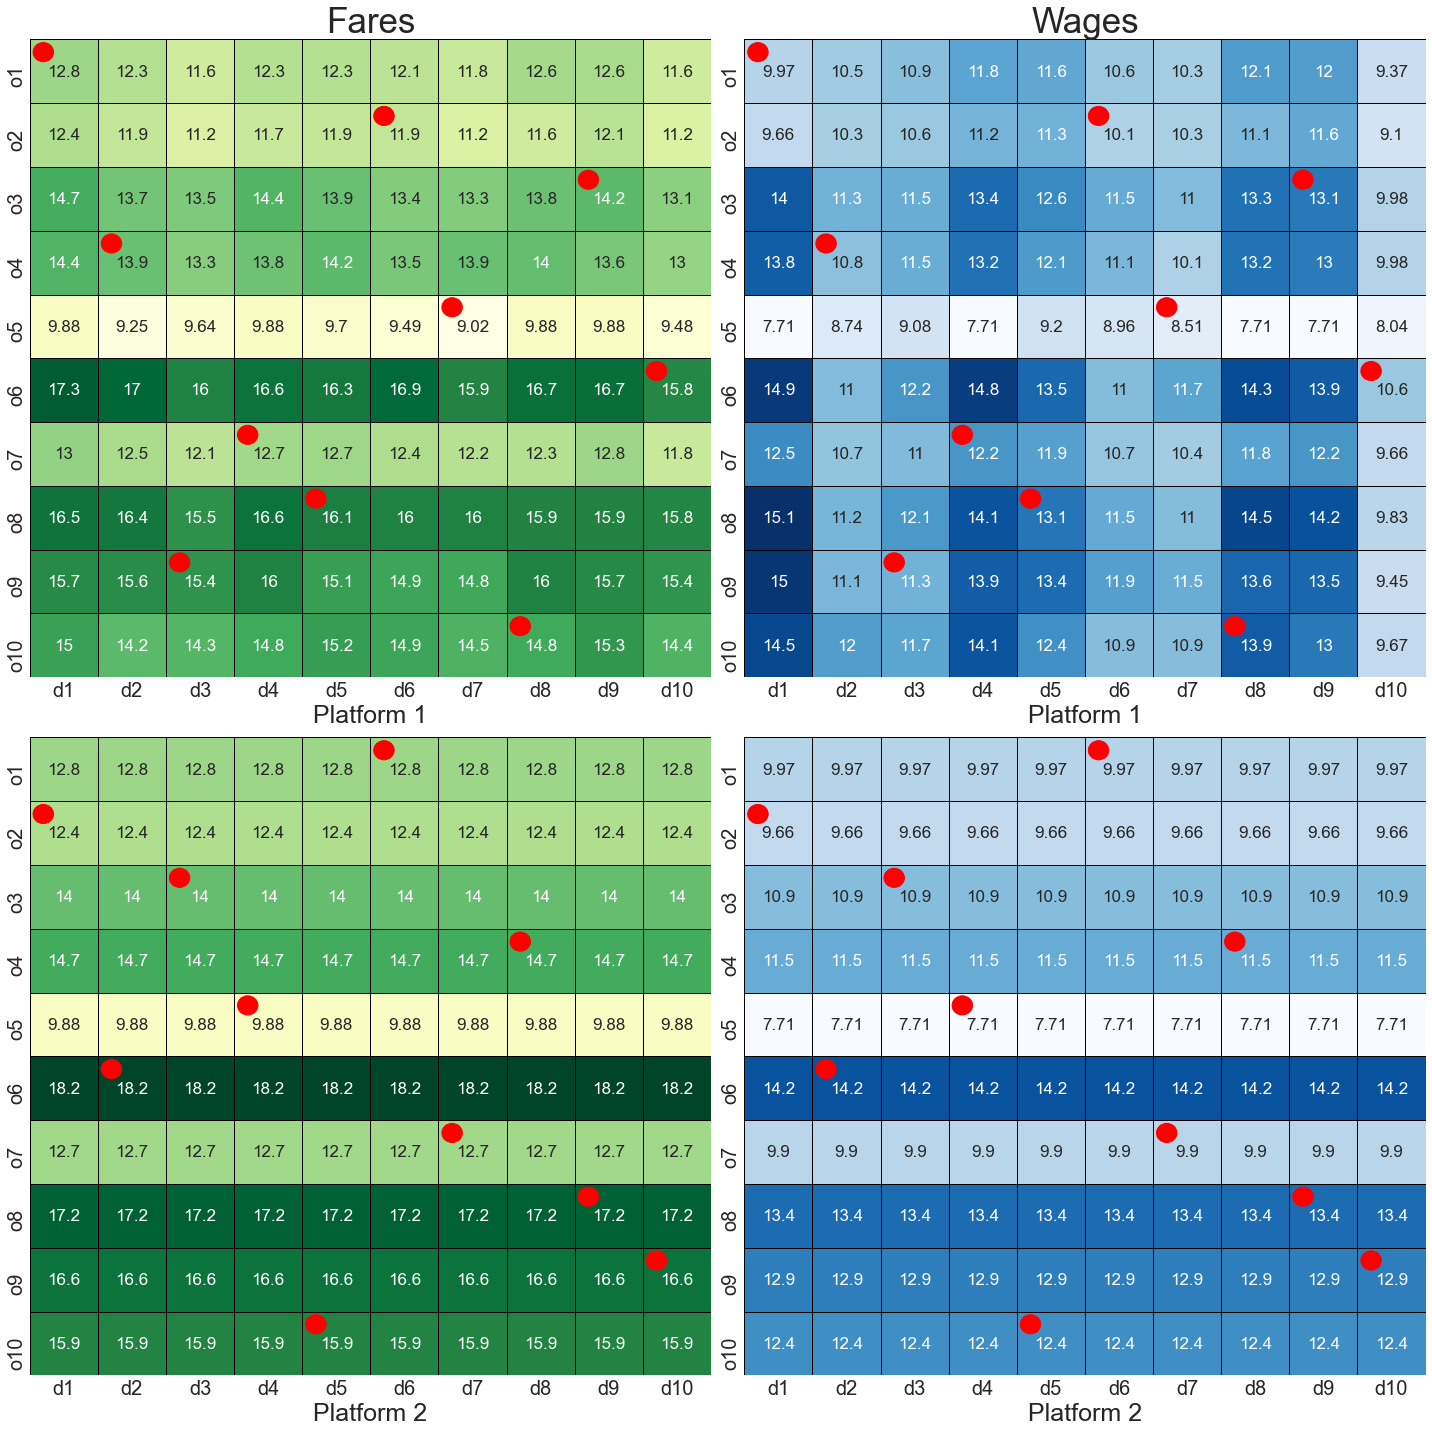

In [69]:
################################################################################################
################################################################################################

Fare1_df=pd.DataFrame(Fare1,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Wage1_df=pd.DataFrame(Wage1,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Fare2_df=pd.DataFrame(Fare2,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

Wage2_df=pd.DataFrame(Wage2,columns=['d'+str(i+1) for i in range(driver_num)],index=['o'+str(i+1) for i in range(order_num)])

################################################################################################
################################################################################################

G1 = nx.Graph()

for node in order_nodes:
    
    G1.add_node(node, level=0)
    
for node in driver_nodes:
    
    G1.add_node(node, level=1)

for o in range(order_num):

    for d in range(driver_num):
        
        if X1[o][d]==1:

            G1.add_edge('o'+str(o+1),'d'+str(d+1))


################################################################################################
################################################################################################

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 35}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(2,2,figsize = (20,20))

################################################################################################
################################################################################################


for i in range(2):
    
    for j in range(2):
    
        labels = axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels()

        [label.set_fontsize(20) for label in labels]

        [label.set_fontname('Arial') for label in labels]
        
################################################################################################
################################################################################################


fmin = min(Fare1_df.values.min(), Fare2_df.values.min())

fmax = max(Fare1_df.values.max(), Fare2_df.values.max())


sns.heatmap(Fare1_df, annot=True, linecolor='black',linewidths=.5,ax=axs[0,0],\
            fmt='.3g',cmap="YlGn",cbar=False,annot_kws={"size":17},\
            vmin=fmin,vmax=fmax)

axs[0,0].set_xlabel('Platform 1',font_label)

axs[0,0].set_title('Fares',font_title)


for x,y in zip(np.where(X1==1)[0],np.where(X1==1)[1]):
    
    circle1 = plt.Circle((x+.2, y+.2), 0.15, color='red')

    axs[0,0].add_patch(circle1)
    
################################################################################################
################################################################################################

wmin = min(Wage1_df.values.min(), Wage2_df.values.min())

wmax = max(Wage1_df.values.max(), Wage2_df.values.max())


sns.heatmap(Wage1_df, annot=True, linecolor='black',linewidths=.5,ax=axs[0,1],\
            fmt='.3g',cmap="Blues",cbar=False,annot_kws={"size":17},\
            vmin=wmin,vmax=wmax)

axs[0,1].set_xlabel('Platform 1',font_label)

axs[0,1].set_title('Wages',font_title)

for x,y in zip(np.where(X1==1)[0],np.where(X1==1)[1]):
    
    circle1 = plt.Circle((x+.2, y+.2), 0.15, color='red')

    axs[0,1].add_patch(circle1)

################################################################################################


sns.heatmap(Fare2_df, annot=True, linecolor='black',linewidths=.5,ax=axs[1,0],\
            fmt='.3g',cmap="YlGn",cbar=False,annot_kws={"size":17},\
            vmin=fmin,vmax=fmax)

axs[1,0].set_xlabel('Platform 2',font_label)


for x,y in zip(np.where(X2==1)[0],np.where(X2==1)[1]):
    
    circle1 = plt.Circle((x+.2, y+.2), 0.15, color='red')

    axs[1,0].add_patch(circle1)
    
################################################################################################
################################################################################################


sns.heatmap(Wage2_df, annot=True, linecolor='black',linewidths=.5,ax=axs[1,1],\
            fmt='.3g',cmap="Blues",cbar=False,annot_kws={"size":17},\
            vmin=wmin,vmax=wmax)

axs[1,1].set_xlabel('Platform 2',font_label)

for x,y in zip(np.where(X2==1)[0],np.where(X2==1)[1]):
    
    circle1 = plt.Circle((x+.2, y+.2), 0.15, color='red')

    axs[1,1].add_patch(circle1)


################################################################################################
################################################################################################

plt.tight_layout()

current_fig = plt.gcf() 

plt.show()



In [70]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################


def Choice(Fare1,Wage1,X1,Fare2,Wage2,X2,u_decline,v_decline):
    
    ################################################################################################
    ################################################################################################
        
    order_num,driver_num=X2.shape[0],X2.shape[1]
    
    ################################################################################################
    ################################################################################################
    
    U1=alpha0*np.ones([order_num,driver_num])-alpha1*Fare1-alpha2*Tau

    V1=beta0*np.ones([order_num,driver_num])+beta1*Wage1-beta2*Tau
    
    U2=alpha0*np.ones([order_num,driver_num])-alpha1*Fare2-alpha2*Tau
    
    V2=beta0*np.ones([order_num,driver_num])+beta1*Wage2-beta2*Tau

    ################################################################################################
    ################################################################################################
    
    order_selection={}
    
    driver_selection={}
    
    ################################################################################################
    ################################################################################################
    
    for o  in range(order_num):
        
        ################################################################################################
        ################################################################################################
        
        choice_set={'decline':u_decline}
        
        ################################################################################################
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[o,:])[0],np.nonzero(X2[o,:])[0]
        
        if len(matching1)>0:
        
            d1=matching1[0]
            
            choice_set['1']=U1[o,d1]
            
        if len(matching2)>0:
            
            d2=matching2[0]
            
            choice_set['2']=U2[o,d2]
            
        ################################################################################################
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        order_selection[o]=selection
        
    ################################################################################################
    ################################################################################################
    
    for d  in range(driver_num):
        
        ################################################################################################
        ################################################################################################
        
        choice_set={'decline':v_decline}
        
        ################################################################################################
        ################################################################################################
        
        matching1,matching2=np.nonzero(X1[:,d])[0],np.nonzero(X2[:,d])[0]
        
        if len(matching1)>0:
        
            o1=matching1[0]
            
            choice_set['1']=V1[o1,d]
            
        if len(matching2)>0:
            
            o2=matching2[0]
            
            choice_set['2']=V2[o2,d]
            
        ################################################################################################
        ################################################################################################
        
        choice_prob={}
        
        exp_sum=sum([np.exp(u) for u in choice_set.values()])
        
        for select,utility in choice_set.items():
            
            choice_prob[select]=np.exp(utility)/exp_sum
            
        ################################################################################################
        ################################################################################################
        
        selection=np.random.choice(list(choice_prob.keys()),p=list(choice_prob.values()))
        
        if selection=='1':
            
            selection=selection+'_'+str(matching1[0])
            
        elif selection=='2':
            
            selection=selection+'_'+str(matching2[0])
            
        else:
            
            selection=selection+'_null'
            
        driver_selection[d]=selection
        
    ################################################################################################
    ################################################################################################

    profit={'1':0,'2':0}
    
    matchings={'1':[],'2':[]}
    
    ################################################################################################
    ################################################################################################
    
    for o,order_select in order_selection.items():
        
        order_platform,d=order_select.split('_')[0],order_select.split('_')[1]
        
        if order_platform!="decline":
            
            d=int(d)
            
            driver_select=driver_selection[d]
            
            driver_platform=driver_select.split('_')[0]
            
            if driver_platform==order_platform:
                
                matchings[driver_platform].append((o,d))
                
                if driver_platform=='1':
                    
                    profit[driver_platform]+=Fare1[o,d]-Wage1[o,d]
                    
                elif driver_platform=='2':
                    
                    profit[driver_platform]+=Fare2[o,d]-Wage2[o,d]
                    
    ################################################################################################
    ################################################################################################

    return profit,matchings


        
profit,matchings=Choice(Fare1,Wage1,X1,Fare2,Wage2,X2,u_decline,v_decline)

profit

{'1': 23.935311453007834, '2': 0}

### thousand episodes of simulation

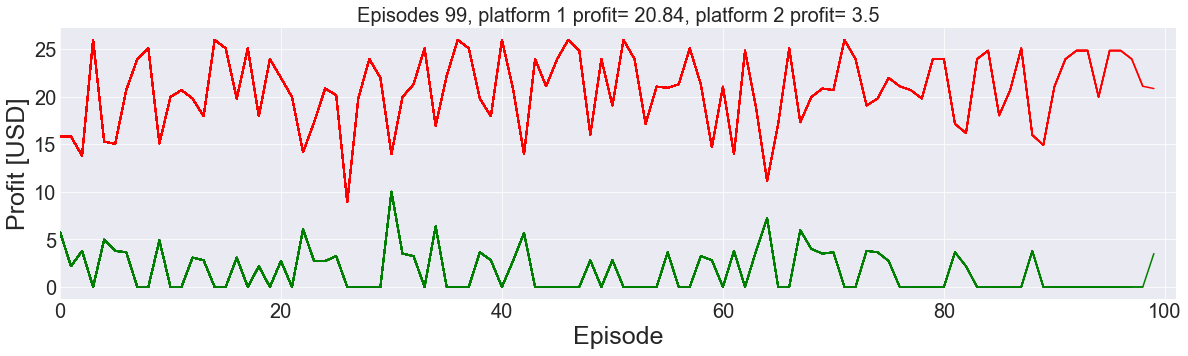

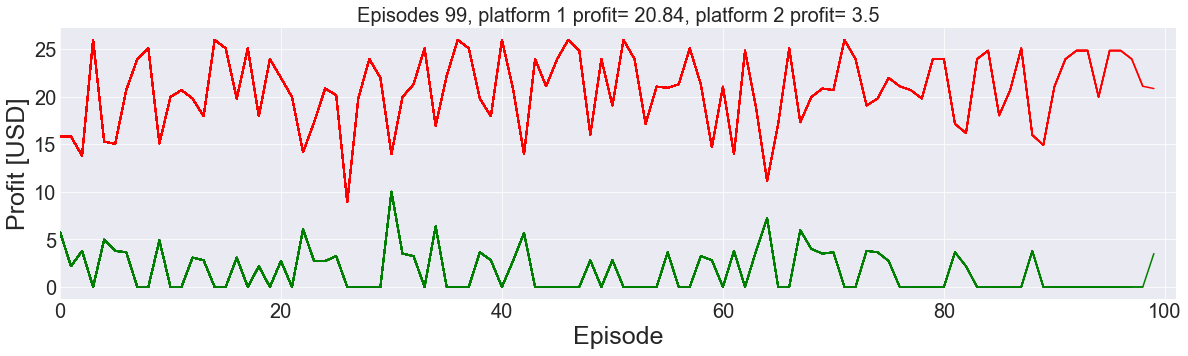

In [71]:
#########################################################################################
#########################################################################################
#########################################################################################
#########################################################################################

plt.style.use('seaborn-v0_8-darkgrid')

#########################################################################################
#########################################################################################

is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    
    from IPython import display
    
plt.ion()

#########################################################################################
#########################################################################################


font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 20}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

#########################################################################################
#########################################################################################

def dynamic_plot(i):
    
    #########################################################################################
    #########################################################################################
    
    plt.figure(1,figsize=(20,5))
    
    ########################################################################################
    #########################################################################################
    
    plt.xticks(fontsize=20,fontfamily='Arial')
    
    plt.yticks(fontsize=20,fontfamily='Arial')
    
    plt.xlim([0,episodes+1])
    
    #########################################################################################
    #########################################################################################

    
    plt.title("Episodes {}, platform 1 profit= {}, platform 2 profit= {}".format(i,round(profits_1[-1],2),round(profits_2[-1],2)),**font_title)
        
    #########################################################################################
    #########################################################################################
    
    plt.xlabel('Episode',**font_label)
    
    plt.ylabel('Profit [USD]',**font_label)
    
    #########################################################################################
    #########################################################################################
    
    plt.plot(profits_1,color='red')
    
    plt.plot(profits_2,color='green')
    
    #########################################################################################
    #########################################################################################
    
    display.clear_output(wait=True)
    
    display.display(plt.gcf())
    
    time.sleep(0.001)

#########################################################################################
#########################################################################################
    
profits_1=list()

profits_2=list()

episodes=100

for i in range(episodes):

    optimization=OS_optimization(Fare2,Wage2,X2,u_decline,v_decline,Tau)

    Fare1,Wage1,X1=optimization.solve()

    profit,matchings=Choice(Fare1,Wage1,X1,Fare2,Wage2,X2,u_decline,v_decline)

    profits_1.append(profit['1'])
    
    profits_2.append(profit['2'])
    
    dynamic_plot(i)
    